**MScFE 600 FINANCIAL DATA** \\
**Group Work Project #2** \\



For collecting and organizing Google Trends data, we make use of the pytrends library which is a Python interface for Google Trends.

This allows for the automated fetch of search data for a given keyword which is then saved as a pandas DataFrame for the financial analysis.

In [105]:
# libraries
from pytrends.request import TrendReq
import pandas as pd

# Initialize the Pytrends connection
pytrends = TrendReq(hl='en-US', tz=360)

# timeframe
kw_list = ["AAPL"]                      # Apple stock ticker
timeframe = "2024-10-01 2025-10-01"

#payload
pytrends.build_payload(kw_list, timeframe=timeframe)

# Retrieve Search Volume Index (SVI) over time
search_interest_df = pytrends.interest_over_time()

# Display first rows
print("SVI over time:")
print(search_interest_df.head())

# Rearch Interest by Region
regional_interest = pytrends.interest_by_region(resolution='COUNTRY', inc_low_vol=True)

# Display first rows
print("\nInterest by Region:")
print(regional_interest.head())



SVI over time:
            AAPL  isPartial
date                       
2024-09-29    33      False
2024-10-06    31      False
2024-10-13    36      False
2024-10-20    34      False
2024-10-27    48      False

Interest by Region:
                AAPL
geoName             
Afghanistan        0
Albania            9
Algeria            1
American Samoa     0
Andorra            0


This code produces a pandas DataFrame containing both search intensity and stock returns, forming the foundation for exploratory and correlation analysis. The resulting structure allows analysts to visualize how shifts in investor attention (SVI) precede or follow price movements.

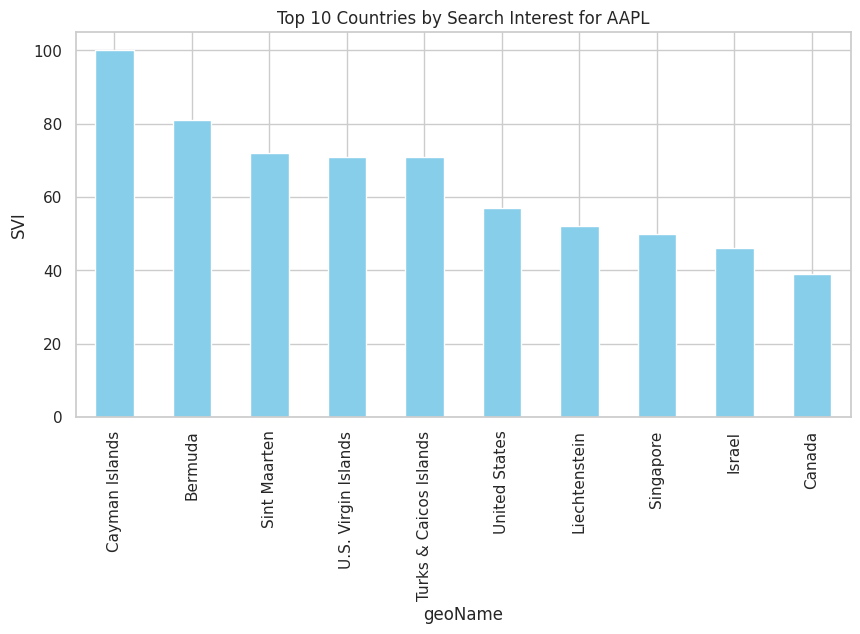

In [116]:
# Sort top 10 regions
top_regions = regional_interest.sort_values(by='AAPL', ascending=False).head(10)

# Bar plot of top regions
top_regions['AAPL'].plot(kind='bar', figsize=(10,5), color='skyblue')
plt.title('Top 10 Countries by Search Interest for AAPL')
plt.ylabel('SVI')
plt.show()


In [118]:
import yfinance as yf
import pandas as pd

# Download historical AAPL data
stock_df = yf.download("AAPL", start="2024-10-01", end="2025-10-01", interval="1d")

# Flatten MultiIndex columns if present
if isinstance(stock_df.columns, pd.MultiIndex):
    stock_df.columns = ['_'.join(col).strip() if col[1] != '' else col[0] for col in stock_df.columns]

# Reset index
stock_df = stock_df.reset_index()

# Rename adjusted close column to simple name
if 'Adj Close_AAPL' in stock_df.columns:
    stock_df.rename(columns={'Adj Close_AAPL':'Adj_Close'}, inplace=True)
elif 'Adj Close' in stock_df.columns:
    stock_df.rename(columns={'Adj Close':'Adj_Close'}, inplace=True)

# Check the columns
print(stock_df.columns)
print(stock_df.head())


/tmp/ipython-input-1604158872.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_df = yf.download("AAPL", start="2024-10-01", end="2025-10-01", interval="1d")
[*********************100%***********************]  1 of 1 completed

Index(['Date', 'Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL',
       'Volume_AAPL'],
      dtype='object')
        Date  Close_AAPL   High_AAPL    Low_AAPL   Open_AAPL  Volume_AAPL
0 2024-10-01  225.162094  228.586146  222.703535  228.456758     63285000
1 2024-10-02  225.729462  226.316725  221.986885  224.843585     32880600
2 2024-10-03  224.624588  225.759306  222.285483  224.097044     34044200
3 2024-10-04  225.749359  226.943797  223.091730  226.844254     37245100
4 2024-10-07  220.663025  224.644495  220.304692  223.460005     39505400


In [119]:
stock_df = stock_df[['Date','Close_AAPL']]


In [120]:

# --- 1. Fetch Google Trends SVI ---
pytrends = TrendReq(hl='en-US', tz=360)
kw_list = ["AAPL"]
timeframe = "2024-10-01 2025-10-01"
pytrends.build_payload(kw_list, timeframe=timeframe)

# Get SVI
search_interest_df = pytrends.interest_over_time().reset_index()
search_interest_df = search_interest_df.rename(columns={'AAPL':'SVI'})
search_interest_df['date'] = pd.to_datetime(search_interest_df['date'])
# Drop partial weeks if any
if 'isPartial' in search_interest_df.columns:
    search_interest_df = search_interest_df[search_interest_df['isPartial']==False]

# Resample SVI weekly (Monday)
svi_weekly = search_interest_df.set_index('date').resample('W-MON').mean().reset_index()
print("SVI weekly head:")
print(svi_weekly.head())

# --- 2. Fetch Stock Prices ---
stock_df = yf.download("AAPL", start="2024-10-01", end="2025-10-01", interval="1d", auto_adjust=True).reset_index()

# Flatten MultiIndex columns if present
if isinstance(stock_df.columns, pd.MultiIndex):
    stock_df.columns = ['_'.join([str(i) for i in col]).strip() if col[1] != '' else col[0] for col in stock_df.columns]

# Detect price column
possible_cols = ['Adj Close', 'Adj_Close', 'Close', 'Close_AAPL', 'Adj Close_AAPL']
price_col = None
for col in possible_cols:
    if col in stock_df.columns:
        price_col = col
        break
if price_col is None:
    raise ValueError("No suitable price column found in stock data!")

stock_df['date'] = pd.to_datetime(stock_df['Date'])
stock_df = stock_df[['date', price_col]].rename(columns={price_col:'Adj_Close'})

# Resample stock weekly (Monday) to match SVI
stock_weekly = stock_df.set_index('date').resample('W-MON').last().reset_index()
print("Stock weekly head:")
print(stock_weekly.head())

# --- 3. Merge SVI and Stock Weekly Data ---
merged_df = pd.merge(svi_weekly[['date','SVI']], stock_weekly, on='date', how='inner')
# Drop any rows with NaN
merged_df = merged_df.dropna(subset=['SVI','Adj_Close'])
print("Merged DataFrame head:")
print(merged_df.head())

# --- 4. Correlation ---
corr = merged_df[['SVI','Adj_Close']].corr()
print("Correlation matrix:\n", corr)

[*********************100%***********************]  1 of 1 completed

SVI weekly head:
        date   SVI  isPartial
0 2024-09-30  33.0        0.0
1 2024-10-07  31.0        0.0
2 2024-10-14  36.0        0.0
3 2024-10-21  34.0        0.0
4 2024-10-28  48.0        0.0
Stock weekly head:
        date   Adj_Close
0 2024-10-07  220.663025
1 2024-10-14  230.228516
2 2024-10-21  235.384506
3 2024-10-28  232.318771
4 2024-11-04  220.981537
Merged DataFrame head:
        date   SVI   Adj_Close
0 2024-10-07  31.0  220.663025
1 2024-10-14  36.0  230.228516
2 2024-10-21  34.0  235.384506
3 2024-10-28  48.0  232.318771
4 2024-11-04  40.0  220.981537
Correlation matrix:
                 SVI  Adj_Close
SVI        1.000000  -0.128975
Adj_Close -0.128975   1.000000


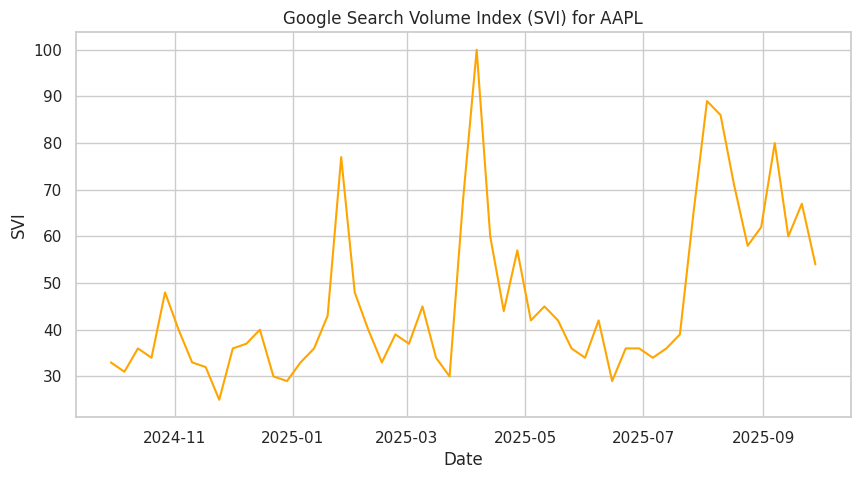

In [121]:
plt.figure(figsize=(10,5))
plt.plot(search_interest_df['date'], search_interest_df['SVI'], color='orange')
plt.title('Google Search Volume Index (SVI) for AAPL')
plt.xlabel('Date')
plt.ylabel('SVI')
plt.show()


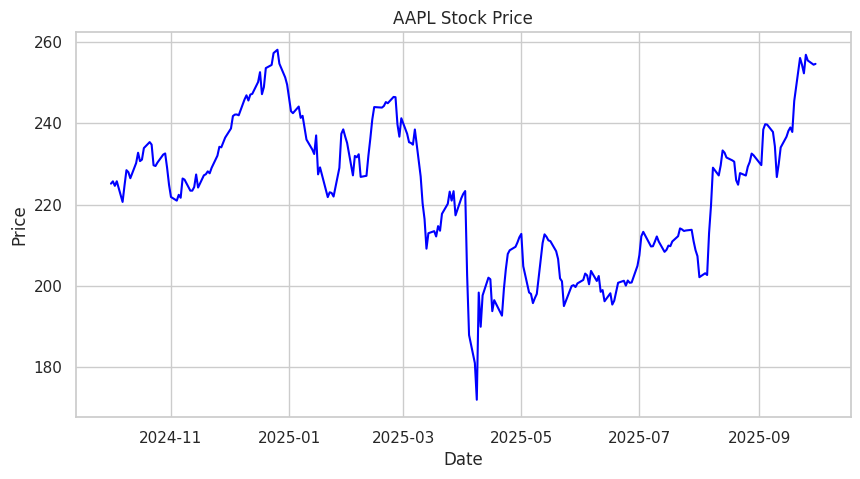

In [122]:
# --- Plot Stock Price only ---
plt.figure(figsize=(10,5))
plt.plot(stock_df['date'], stock_df['Adj_Close'], color='blue')
plt.title('AAPL Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

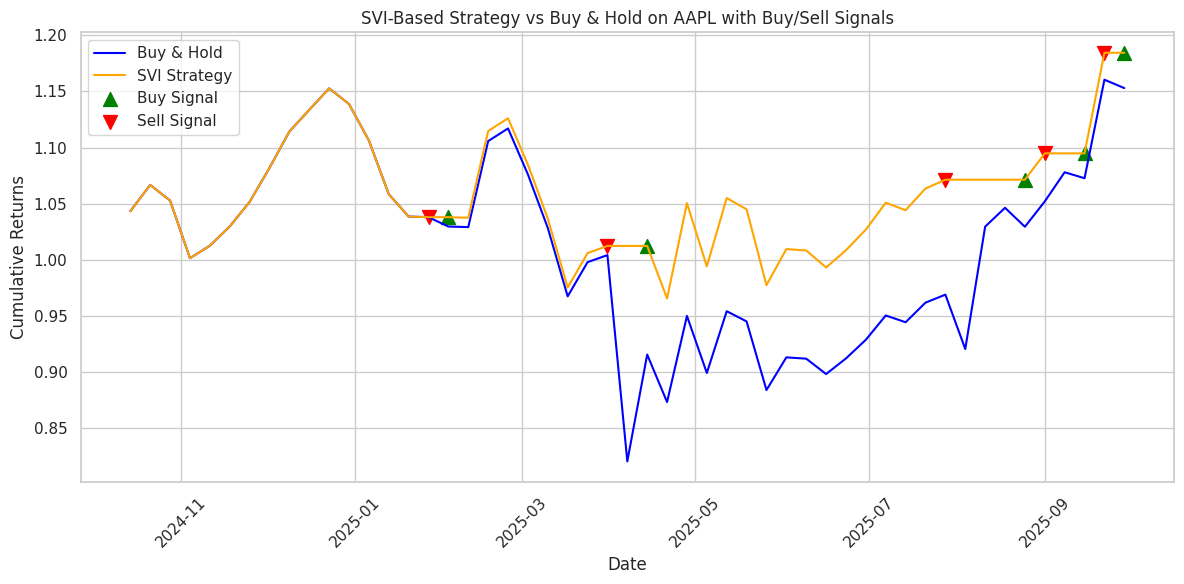

In [123]:


#  avoid overwriting
df = merged_df.copy()

# -Generate SVI trading signals
svi_threshold = 60
df['Signal'] = 0
df.loc[df['SVI'] <= svi_threshold, 'Signal'] = 1

# Calculate strategy returns
df['Returns'] = df['Adj_Close'].pct_change()
df['Strategy_Returns'] = df['Signal'].shift(1) * df['Returns']  # Shift to avoid lookahead bias

#  Compute cumulative returns
df['Cumulative_BuyHold'] = (1 + df['Returns']).cumprod()
df['Cumulative_SVI_Strategy'] = (1 + df['Strategy_Returns']).cumprod()

# Identify buy/sell points
df['Signal_Change'] = df['Signal'].diff()
buy_signals = df[df['Signal_Change'] == 1]
sell_signals = df[df['Signal_Change'] == -1]

# Plot cumulative returns with buy/sell markers
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['Cumulative_BuyHold'], label='Buy & Hold', color='blue')
plt.plot(df['date'], df['Cumulative_SVI_Strategy'], label='SVI Strategy', color='orange')

# Plot Buy/Sell markers
plt.scatter(buy_signals['date'], buy_signals['Cumulative_SVI_Strategy'], marker='^', color='green', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['Cumulative_SVI_Strategy'], marker='v', color='red', s=100, label='Sell Signal')

plt.title('SVI-Based Strategy vs Buy & Hold on AAPL with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
